# Processing IMERG data with COGs backend

In [1]:
import tqdm
import xarray as xr 
import pandas as pd
import os
from dotenv import load_dotenv
from azure.storage.blob import ContainerClient
import rioxarray as rxr
import io
import zipfile
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime
from dask.distributed import Client, LocalCluster

client = Client(LocalCluster(n_workers=4, threads_per_worker=2, memory_limit='2GB'))

load_dotenv()

DEV_BLOB_SAS = os.getenv("DEV_BLOB_SAS")
DEV_BLOB_NAME = "imb0chd0dev"
IMERG_ZARR_ROOT = "az://global/imerg.zarr"
DEV_BLOB_URL = f"https://{DEV_BLOB_NAME}.blob.core.windows.net/"
DEV_BLOB_PROJ_URL = DEV_BLOB_URL + "projects" + "?" + DEV_BLOB_SAS
GLOBAL_CONTAINER_NAME = "global"
DEV_BLOB_GLB_URL = (DEV_BLOB_URL + GLOBAL_CONTAINER_NAME + "?" + DEV_BLOB_SAS)

dev_container_client = ContainerClient.from_container_url(DEV_BLOB_PROJ_URL)
dev_glb_container_client = ContainerClient.from_container_url(DEV_BLOB_GLB_URL)

def _load_blob_data(blob_name):
    container_client = dev_container_client
    blob_client = container_client.get_blob_client(blob_name)
    data = blob_client.download_blob().readall()
    return data

def _load_gdf_from_blob(blob_name, shapefile: str = None):
    blob_data = _load_blob_data(blob_name)
    with zipfile.ZipFile(io.BytesIO(blob_data), "r") as zip_ref:
        zip_ref.extractall("temp")
        if shapefile is None:
            shapefile = [f for f in zip_ref.namelist() if f.endswith(".shp")][
                0
            ]
        gdf = gpd.read_file(f"temp/{shapefile}")
    return gdf

/Users/hannahker/Desktop/ds-raster-explore/venv/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61965 instead
  warnings.warn(


In [2]:
gdf = _load_gdf_from_blob(
    "ds-aa-hti-hurricanes/raw/codab/hti.shp.zip",
    shapefile="hti_adm0.shp"
)

minx, miny, maxx, maxy = gdf.total_bounds

Since the COGs are stored as individual files, we need to start by extracting the list of all relevant file names. We're selecting a subset of the data here so that we're working with a comparable volume to the Zarr IMERG dataset (which contains 2033 dates).

In [3]:
blob_names = existing_files = [
    x.name
    for x in dev_glb_container_client.list_blobs(
        name_starts_with="imerg/v6/"
    )
]

def extract_date(filename):
    date_str = '-'.join(filename.split('-')[-3:]).split('.')[0]
    return datetime.strptime(date_str, "%Y-%m-%d")

start_date = datetime(2003, 6, 1)
end_date = datetime(2008, 12, 31)

filtered_filenames = [
    filename for filename in blob_names
    if start_date <= extract_date(filename) <= end_date
]

blob_names = sorted(filtered_filenames, key=extract_date)

We need to loop through each file individually and build up an `xarray` object that covers the whole time series. We can also use this opportunity to subset the data to the bounding box of the area that we're interested in. 

Each file will also be loaded in lazily. However, it seems to be more efficient to trigger computation on the underlying Dask arrays using the `persist()` function. Since we're clipping the dataset to an area of interest (eg. the Haiti bounding box), we don't need to worry about holding too much data in memory. 

Reading in and clipping all 2041 files takes approximately **5mins** and gives us an output dataset of ~4MB. 

In [33]:
das = []
for blob_name in tqdm.tqdm(blob_names):
    cog_url = (
        f"https://{DEV_BLOB_NAME}.blob.core.windows.net/global/"
        f"{blob_name}?{DEV_BLOB_SAS}"
    )
    da_in = rxr.open_rasterio(
        cog_url, masked=True, chunks={"band": 1, "x": 225, "y": 900}
    )
    da_in = da_in.sel(x=slice(minx, maxx), y=slice(miny, maxy))
    date_in = pd.to_datetime(blob_name.split(".")[0][-10:])
    da_in["date"] = date_in

    # Persisting to reduce the number of downstream Dask layers
    da_in = da_in.persist()
    das.append(da_in)

ds = xr.concat(das, dim="date", join='override', combine_attrs='drop')


100%|██████████| 2041/2041 [05:14<00:00,  6.49it/s]


In [37]:
ds

<xarray.DataArray (date: 2041, band: 1, y: 21, x: 29)> Size: 5MB
dask.array<concatenate, shape=(2041, 1, 21, 29), dtype=float32, chunksize=(1, 1, 21, 29), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 232B -74.45 -74.35 -74.25 ... -71.85 -71.75 -71.65
  * y            (y) float64 168B 18.05 18.15 18.25 18.35 ... 19.85 19.95 20.05
    spatial_ref  int64 8B 0
  * date         (date) datetime64[ns] 16kB 2003-06-01 2003-06-02 ... 2008-12-31

Computing the mean on this dataset now takes **~1.5s**, and can be plotted in <1s. 

In [35]:
mean = ds.mean(dim="date").compute()

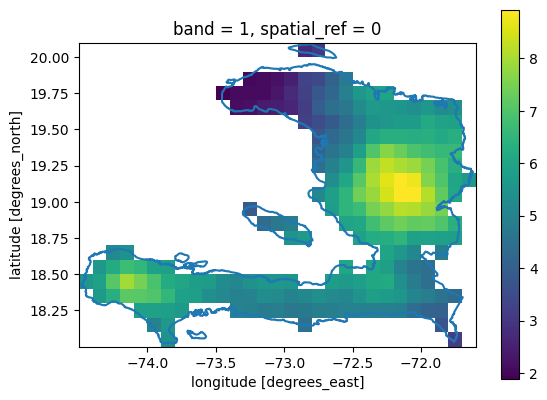

In [36]:
da_box = mean.rio.write_crs(4326)
da_box = da_box.rio.set_spatial_dims(x_dim="x", y_dim="y")
da_clip = da_box.rio.clip(gdf.geometry)

fig, ax = plt.subplots()
gdf.boundary.plot(ax=ax)
da_clip.plot(ax=ax)